In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import mahalanobis

In [2]:
SIGNAL_FEATURE = ['mbp', 'sbp', 'dbp', 'hr', 'rr', 'spo2', 'etco2', 'mac', 'pp_ct', 'rf_ct', 'body_temp']
STATIC_FEATURE = ["age", "bmi", "asa"]
HALF_TIME_FILTERING = [60, 3*60, 10*60]

In [3]:
# import the data frame and add the meta data to the segments

dataset_name = '30_s_remi_dataset'
model_filename = 'xgb_30_s_remi.json'

data = pd.read_parquet(Path(f'data/datasets/{dataset_name}/cases/'))

static = pd.read_parquet(f'data/datasets/{dataset_name}/meta.parquet')

data = data.merge(static, on='caseid')

train = data[data['split'] == "train"]
test = data[data['split'] == "test"]

In [4]:
# control reproducibility
rng_seed = 42


FEATURE_NAME = (
    [
        f"{signal}_constant_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_slope_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + [
        f"{signal}_std_{half_time}"
        for signal in SIGNAL_FEATURE
        for half_time in HALF_TIME_FILTERING
    ]
    + STATIC_FEATURE
)

#remove feature with std_60 in the name
FEATURE_NAME = [x for x in FEATURE_NAME if "std_30" not in x]


# create a regressor
train = train.dropna(subset=FEATURE_NAME)
test = test.dropna(subset=FEATURE_NAME)

Train_mean = train[FEATURE_NAME].mean(axis=0)
Train_std = np.cov(train[FEATURE_NAME].to_numpy(), rowvar=False)
Train_std_inv = np.linalg.inv(Train_std)

In [5]:
def compute_mahalanobis_distance(new_data, mean_ref, inv_cov_matrix):
    distances = []
    for x in new_data:
        dist = mahalanobis(x, mean_ref, inv_cov_matrix)
        distances.append(dist)
    return np.array(distances)

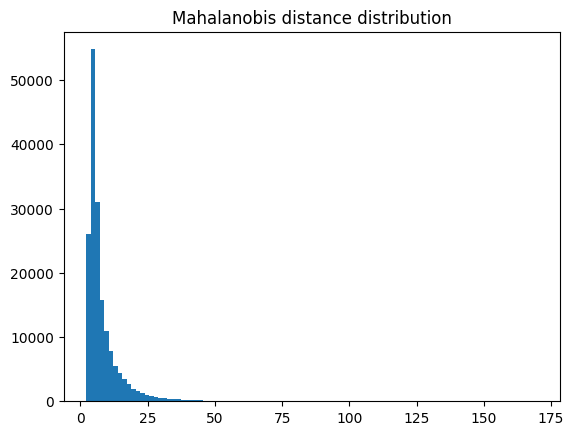

In [6]:
# compute the mahalanobis distance on the test set

test['mahalanobis'] = compute_mahalanobis_distance(test[FEATURE_NAME].to_numpy(), Train_mean, Train_std_inv)
train['mahalanobis'] = compute_mahalanobis_distance(train[FEATURE_NAME].to_numpy(), Train_mean, Train_std_inv)

# display the distribution of the mahalanobis distance
plt.hist(test['mahalanobis'], bins=100)
plt.title('Mahalanobis distance distribution')
plt.show()


In [7]:
# import chu data
# import the data frame and add the meta data to the segments
data = pd.DataFrame()
dataset_name = 'chu_dataset'
for file in Path(f'data/datasets/{dataset_name}/cases/').glob('*'):
    try:
        df = pd.read_parquet(file)
        data = pd.concat([data, df], ignore_index=True)
    except Exception as e:
        print(f"Error with file: {file}")
        print(e)
data['label_id'] = data['label_id'].astype(str) + "_" + data['caseid'].astype(str)

static = pd.read_parquet('data/datasets/chu_dataset/meta.parquet')
data = data.merge(static, on='caseid')


test_chu = data.dropna(subset=FEATURE_NAME)

test_chu['mahalanobis'] = compute_mahalanobis_distance(test_chu[FEATURE_NAME].to_numpy(), Train_mean, Train_std_inv)


/tmp/ipykernel_158940/3016575268.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chu['mahalanobis'] = compute_mahalanobis_distance(test_chu[FEATURE_NAME].to_numpy(), Train_mean, Train_std_inv)


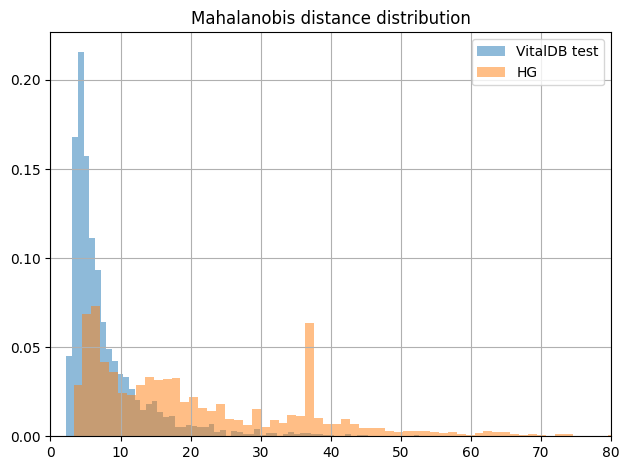

,chu,vdb
0,32.272646,25.904846
50,13.318279,11.087671
100,9.977161,3.929040
150,5.547899,6.534216
200,9.151783,2.737231


In [8]:
# compare the distribution of the mahalanobis distance between the two datasets
plt.hist(test['mahalanobis'][::50], bins=100, alpha=0.5, label='VitalDB test', density=True)
plt.hist(test_chu['mahalanobis'][::50], bins=100, alpha=0.5, label='HG', density=True)
# plt.hist(train['mahalanobis'], bins=100, alpha=0.5, label='VitalDB train', density=True)
plt.title('Mahalanobis distance distribution')
plt.legend()
plt.xlim(0, 80)
plt.grid()
plt.tight_layout()
plt.savefig('mahalanobis_distance.pdf', format='pdf')
plt.show()
data_out = pd.DataFrame()
data_out['chu'] = test_chu['mahalanobis'].to_numpy()
data_out['vdb'] = np.random.choice(test['mahalanobis'].to_numpy(), len(test_chu), replace=False)
data_out[::50].to_csv('output/compare_maha.csv')
data_out[::50].head()

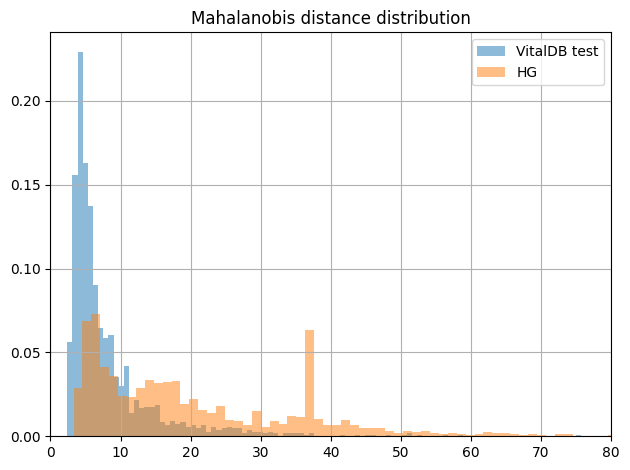

In [9]:
plt.hist(data_out['vdb'][::50], bins=100, alpha=0.5, label='VitalDB test', density=True)
plt.hist(data_out['chu'][::50], bins=100, alpha=0.5, label='HG', density=True)
# plt.hist(train['mahalanobis'], bins=100, alpha=0.5, label='VitalDB train', density=True)
plt.title('Mahalanobis distance distribution')
plt.legend()
plt.xlim(0, 80)
plt.grid()
plt.tight_layout()
plt.show()

In [10]:
# define a threshold for the mahalanobis distance to detect 97% of the normal cases
threshold = np.percentile(test['mahalanobis'], 97)
print(f"Threshold for the mahalanobis distance: {threshold}")
# count the number of abnormal cases in the chu dataset in percentage
print(f"Percentage of abnormal cases in the chu dataset: {np.sum(test_chu['mahalanobis'] > threshold) / len(test_chu) :.2%}")

Threshold for the mahalanobis distance: 25.477762729639398
Percentage of abnormal cases in the chu dataset: 31.91%


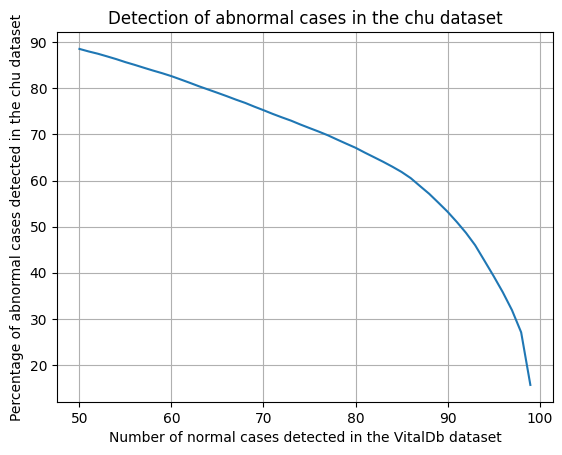

In [11]:
true_classification = np.arange(50, 100, 1)
thr_classification = np.percentile(test['mahalanobis'], true_classification)
chu_classification = np.array([np.sum(test_chu['mahalanobis'] > thr) / len(test_chu) *100 for thr in thr_classification])

plt.plot(true_classification, chu_classification)
plt.xlabel('Number of normal cases detected in the VitalDb dataset')
plt.ylabel('Percentage of abnormal cases detected in the chu dataset')
plt.title('Detection of abnormal cases in the chu dataset')
plt.grid()
plt.show()

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def compute_confidence_scores_for_new_distances(ref_distances, new_distances, in_dist_threshold=95):
    """
    Compute confidence scores for an array of new Mahalanobis distances based on reference distances.
    
    Parameters:
    - ref_distances: array-like, Mahalanobis distances of the reference dataset (in-distribution examples).
    - new_distances: array-like, Mahalanobis distances of the new data points.
    - in_dist_threshold: float, percentile for in-distribution threshold (default is 95th percentile).
    
    Returns:
    - confidence_scores: array-like, scaled confidence scores between 0 and 100 for each new distance.
    """
    # Ensure ref_distances and new_distances are NumPy arrays
    ref_distances = np.array(ref_distances)
    new_distances = np.array(new_distances)
    
    # Step 1: Compute the in-distribution threshold (e.g., 95th percentile of reference distances)
    in_dist_threshold_value = np.percentile(ref_distances, in_dist_threshold)
    
    # Step 2: Create masks for in-distribution and out-of-distribution new distances
    in_dist_mask = new_distances <= in_dist_threshold_value
    out_dist_mask = new_distances > in_dist_threshold_value
    
    # Initialize an array for confidence scores
    confidence_scores = np.zeros_like(new_distances)
    
    # Step 3a: Min-Max scaling for in-distribution distances (from 90 to 100)
    if np.any(in_dist_mask):
        scaler_in_dist = MinMaxScaler(feature_range=(90, 100))
        confidence_scores[in_dist_mask] = scaler_in_dist.fit_transform(-
            new_distances[in_dist_mask].reshape(-1, 1)
        ).flatten()
    
    # Step 3b: Min-Max scaling for out-of-distribution distances (from 0 to 90)
    if np.any(out_dist_mask):
        scaler_out_dist = MinMaxScaler(feature_range=(0, 90))
        confidence_scores[out_dist_mask] = scaler_out_dist.fit_transform(-
            new_distances[out_dist_mask].reshape(-1, 1)
        ).flatten()
    
    # Step 4: Clip any negative values to 0 (though unlikely in this case)
    confidence_scores = np.clip(confidence_scores, 0, 100)
    
    return confidence_scores



/tmp/ipykernel_158940/3610113052.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chu['confidence_score'] = compute_confidence_scores_for_new_distances(test['mahalanobis'], test_chu['mahalanobis'])


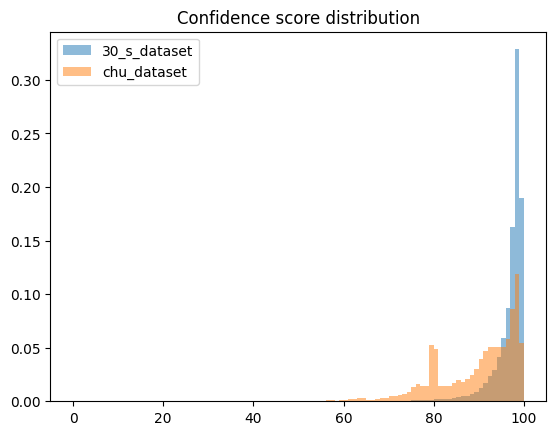

In [13]:
# compute the confidence score for both datasets

test['confidence_score'] = compute_confidence_scores_for_new_distances(test['mahalanobis'], test['mahalanobis'])


test_chu['confidence_score'] = compute_confidence_scores_for_new_distances(test['mahalanobis'], test_chu['mahalanobis'])


# display the distribution of the confidence score
plt.hist(test['confidence_score'], bins=100, alpha=0.5, label='30_s_dataset', density=True)
plt.hist(test_chu['confidence_score'], bins=100, alpha=0.5, label='chu_dataset', density=True)
plt.title('Confidence score distribution')
plt.legend()
plt.show()

/tmp/ipykernel_158940/1868636395.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_chu['mahalanobis_static'] = compute_mahalanobis_distance(test_chu[FEATURE_NAME].to_numpy(), Train_mean, Train_std_inv)


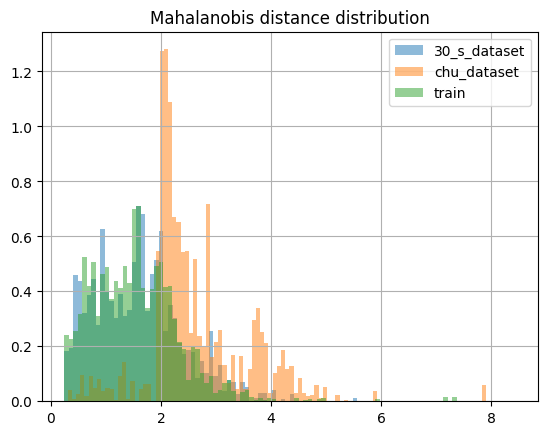

In [14]:
# Same analysis but only with static features

FEATURE_NAME = STATIC_FEATURE

Train_mean = train[FEATURE_NAME].mean(axis=0)
Train_std = np.cov(train[FEATURE_NAME].to_numpy(), rowvar=False)
Train_std_inv = np.linalg.inv(Train_std)

test['mahalanobis_static'] = compute_mahalanobis_distance(test[FEATURE_NAME].to_numpy(), Train_mean, Train_std_inv)
train['mahalanobis_static'] = compute_mahalanobis_distance(train[FEATURE_NAME].to_numpy(), Train_mean, Train_std_inv)
test_chu['mahalanobis_static'] = compute_mahalanobis_distance(test_chu[FEATURE_NAME].to_numpy(), Train_mean, Train_std_inv)

plt.hist(test['mahalanobis_static'], bins=100, alpha=0.5, label='30_s_dataset', density=True)
plt.hist(test_chu['mahalanobis_static'], bins=100, alpha=0.5, label='chu_dataset', density=True)
plt.hist(train['mahalanobis_static'], bins=100, alpha=0.5, label='train', density=True)
plt.title('Mahalanobis distance distribution')
plt.legend()
plt.grid()
plt.show()

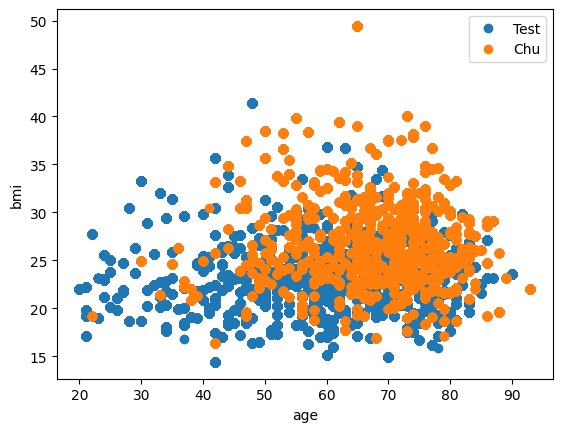

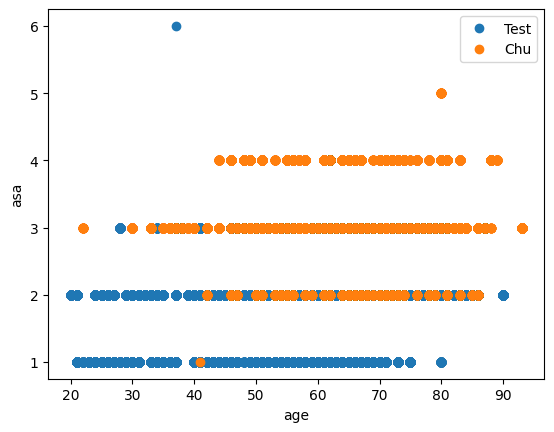

In [15]:
plt.plot(test[STATIC_FEATURE[0]], test[STATIC_FEATURE[1]], 'o', label='Test')
plt.plot(test_chu[STATIC_FEATURE[0]], test_chu[STATIC_FEATURE[1]], 'o', label='Chu')

plt.xlabel(STATIC_FEATURE[0])
plt.ylabel(STATIC_FEATURE[1])
plt.legend()
plt.show()

plt.plot(test[STATIC_FEATURE[0]], test[STATIC_FEATURE[2]], 'o', label='Test')
plt.plot(test_chu[STATIC_FEATURE[0]], test_chu[STATIC_FEATURE[2]], 'o', label='Chu')

plt.xlabel(STATIC_FEATURE[0])
plt.ylabel(STATIC_FEATURE[2])
plt.legend()
plt.show()

In [16]:
# define a threshold for the mahalanobis distance to detect 97% of the normal cases
threshold = np.percentile(test['mahalanobis_static'], 95)
print(f"Threshold for the mahalanobis distance: {threshold}")
# count the number of abnormal cases in the chu dataset in percentage
print(f"Percentage of abnormal cases in the chu dataset: {np.sum(test_chu['mahalanobis_static'] > threshold) / len(test_chu) :.2%}")
# print the caseid of the abnormal cases
print(test_chu[test_chu['mahalanobis_static'] > threshold].caseid.unique())

Threshold for the mahalanobis distance: 3.0379215301076163
Percentage of abnormal cases in the chu dataset: 24.67%
['247' '384' '94' '532' '216' '53' '447' '388' '559' '25' '148' '232'
 '397' '399' '177' '103' '222' '315' '560' '547' '474' '431' '501' '488'
 '249' '15' '70' '162' '457' '246' '352' '541' '190' '305' '348' '236'
 '35' '120' '2' '92' '199' '493' '502' '460' '368' '385' '98' '62' '437'
 '544' '550' '461' '470' '146' '277' '261' '517' '9' '156' '193' '57'
 '446' '374' '227' '23' '531' '587' '313' '137' '510' '400' '37' '10'
 '314' '109' '251' '293' '97' '588' '215' '7' '345' '107' '1' '165' '512'
 '320' '44' '11' '200' '518' '480' '573' '524' '353' '482' '299' '178'
 '42' '17' '568' '24' '274' '240' '485' '126' '342' '576' '188' '358'
 '143' '468' '406' '78' '373' '420' '540' '203' '167' '191' '217' '366'
 '362' '330' '51' '73' '427' '128' '328' '262' '583' '322' '144' '8' '194'
 '174']


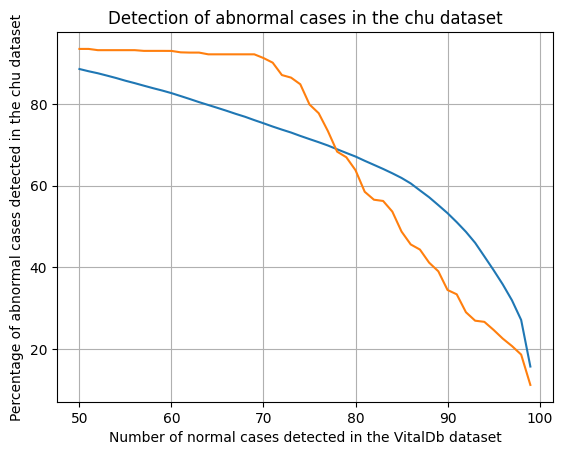

In [17]:
true_classification = np.arange(50, 100, 1)
thr_classification_stat = np.percentile(test['mahalanobis_static'], true_classification)
chu_classification_stat = np.array([np.sum(test_chu['mahalanobis_static'] > thr) / len(test_chu) *100 for thr in thr_classification_stat])

plt.plot(true_classification, chu_classification)
plt.plot(true_classification, chu_classification_stat)
plt.xlabel('Number of normal cases detected in the VitalDb dataset')
plt.ylabel('Percentage of abnormal cases detected in the chu dataset')
plt.title('Detection of abnormal cases in the chu dataset')
plt.grid()
plt.show()